In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# words = open('../dognames.txt').read().splitlines()
words = open('../names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
vocab_size = len(set(''.join(words))) + 1 # +1 for the padding symbol

chars = sorted(list(set(''.join(words)))) # sorted list of unique characters
chars = ['.'] + chars # add padding symbol to the beginning of the list
stoi = {c:i for i,c in enumerate(chars)} # char to index mapping
itos = {i:c for i,c in enumerate(chars)} # index to char mapping

print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
block_size = 3 # context size

# build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        chs = '.' + w + '.'
        for ch1, ch2 in zip(chs, chs[1:]):
            context = context[1:] + [stoi[ch1]]
            # print(''.join(itos[i] for i in context), '->', ch2)
            X.append(context)
            Y.append(stoi[ch2])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

# train, validation, test split

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [ ]:
X_train.shape, X_val.shape, X_test.shape

In [ ]:
emb_dim = 10 # embedding dimension
n_hidden = 200 # hidden layer size
# parameters
C = torch.randn((vocab_size, emb_dim))
W1 = torch.randn((block_size * emb_dim, n_hidden)) * ((5 / 3) / ((block_size * emb_dim) ** 0.5))
B1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
B2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, B1, W2, B2, bnbias, bngain]

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

In [58]:
# hyperparameters
minibatch_size = 128
lr_train = 0.55

In [ ]:
#  minibatch
ix = torch.randint(0, X_train.shape[0], (minibatch_size,))
# forward pass
emb = C[X_train[ix]]
hpreact = emb.view((-1, block_size * emb_dim)) @ W1 + B1
h = torch.tanh(hpreact)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y_train[ix])
# track stats
print(loss.item())

In [ ]:
# initial hidden layer activations distribution
plt.hist(h.view(-1).tolist(), bins=50);

In [ ]:
# initial hidden layer pre activations distribution
plt.hist(hpreact.view(-1).tolist(), bins=50);

In [ ]:
# initial hidden layer neurons saturation
plt.figure(figsize=(10, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [ ]:
lossi = []

In [ ]:
max_iters = 200000
# training loop
for i in range(max_iters):
    #  minibatch
    ix = torch.randint(0, X_train.shape[0], (minibatch_size,))
    # forward pass
    emb = C[X_train[ix]]
    hpreact = emb.view((-1, block_size * emb_dim)) @ W1 # + B1 no need for bias in batchnorm
    # batchnorm
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) - bnbias
    
    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y_train[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lr_train if i < 100000 else lr_train * 0.1
    for p in parameters:
        p.data -= lr * p.grad
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_iters:7d} {loss.item():.4f}')
    lossi.append(loss.log10().item())

In [ ]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm

with torch.no_grad():
    emb = C[X_train]
    hpreact = emb.view((-1, block_size * emb_dim)) @ W1 + B1
    # measure the mean and variance of the pre-activation
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test),
    }[split]
    emb = C[x]
    embcat = emb.view((emb.shape[0], block_size * emb_dim))
    hpreact = embcat @ W1 + B1
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) - bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('val')

In [ ]:
# generating names
for i in range(10):
    out = []
    ixs = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor(ixs)]
        h = emb.view((1, block_size * emb_dim)) @ W1 + B1
        h = torch.tanh(h)
        logits = h @ W2 + B2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, replacement=True).item()
        if ix == 0:
            break
        ixs = ixs[1:] + [ix]
        out.append(itos[ix])
    print(''.join(out))

In [66]:
# pytorchifing the deep learning code

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # make last layer less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"number of parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

number of parameters: 47551


In [67]:
# training
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
        
    # logging
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i > 1000:
        break

      0/200000: 3.3041


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.06%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.00%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 1.78%


Text(0.5, 1.0, 'Histograms of forward activations')

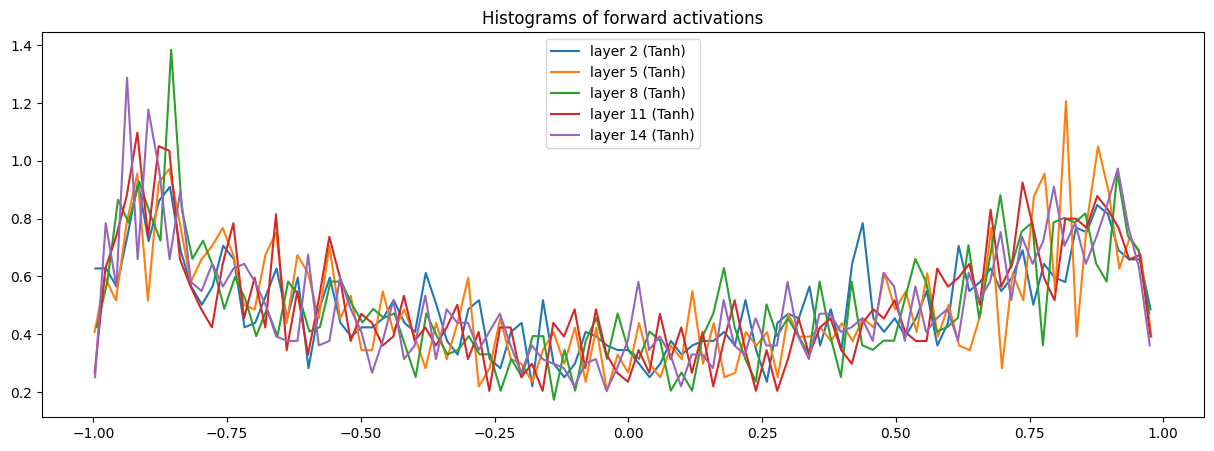

In [68]:
# visualize histograms of tanh activations
plt.figure(figsize=(15, 5))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (
            i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Histograms of forward activations')

layer 2 (      Tanh): mean -0.00, std 3.119499e-03
layer 5 (      Tanh): mean -0.00, std 2.733353e-03
layer 8 (      Tanh): mean -0.00, std 2.533399e-03
layer 11 (      Tanh): mean -0.00, std 2.354109e-03
layer 14 (      Tanh): mean -0.00, std 2.403584e-03


Text(0.5, 1.0, 'Histograms of gradients')

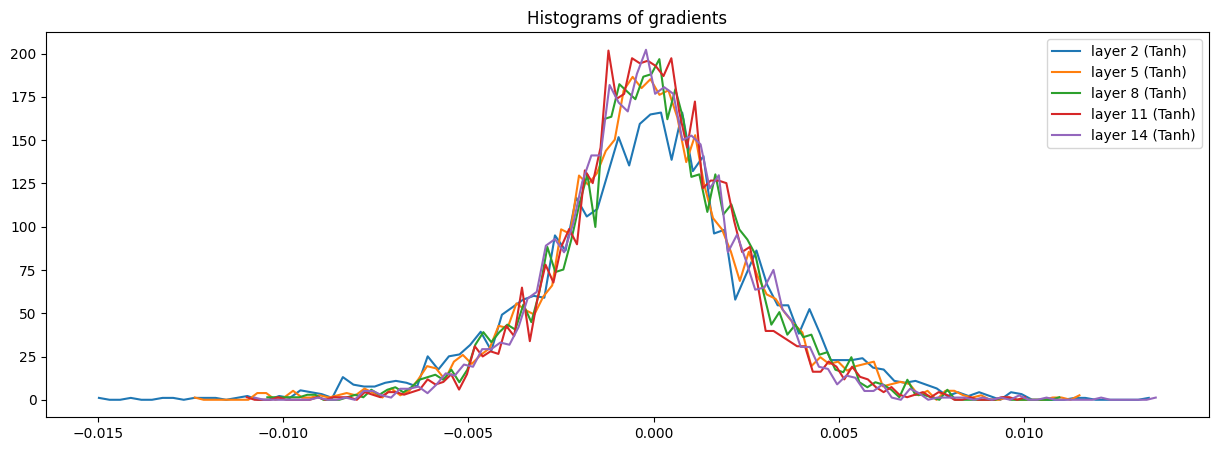

In [69]:
# visualize histograms of gradients
plt.figure(figsize=(15, 5))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Histograms of gradients')

weight   (27, 10) | mean -0.000000 | std 9.222222e-03 | grad:data ratio 9.573123e-03
weight  (30, 100) | mean +0.000053 | std 7.380947e-03 | grad:data ratio 2.482995e-02
weight (100, 100) | mean +0.000162 | std 6.069517e-03 | grad:data ratio 3.657419e-02
weight (100, 100) | mean -0.000002 | std 5.005988e-03 | grad:data ratio 2.964973e-02
weight (100, 100) | mean +0.000057 | std 4.475774e-03 | grad:data ratio 2.685246e-02
weight (100, 100) | mean +0.000038 | std 4.552066e-03 | grad:data ratio 2.719910e-02
weight  (100, 27) | mean +0.000178 | std 8.196636e-03 | grad:data ratio 4.808528e-02


Text(0.5, 1.0, 'Histograms of weights gradient')

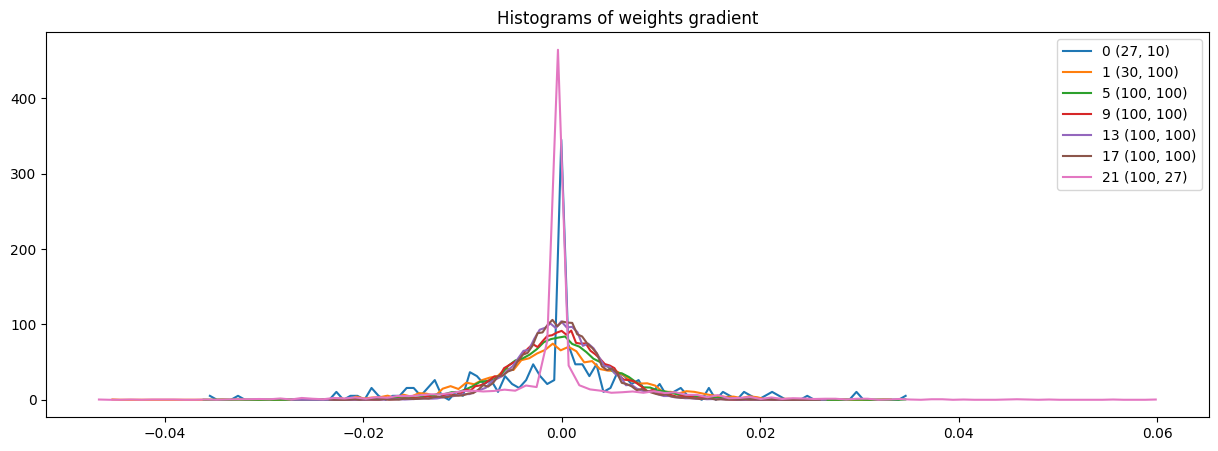

In [70]:
# visualize histograms of weights
plt.figure(figsize=(15, 5))
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Histograms of weights gradient')

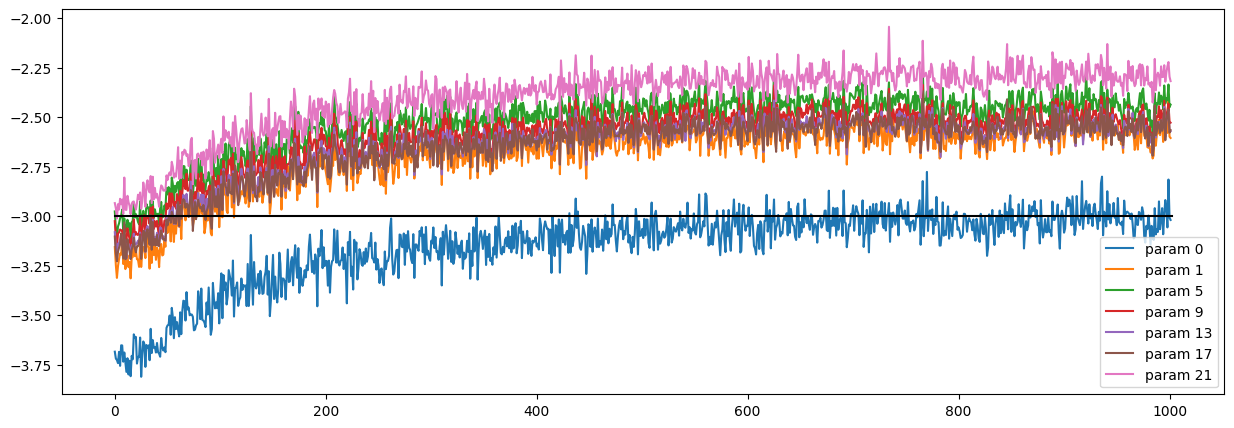

In [71]:
plt.figure(figsize=(15, 5))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)